# Single cell analysis

In [1]:
# try:
#     import varseek as vk
# except ImportError:
#     print("varseek not found, installing...")
#     !pip install -U -q varseek
# try:
#     import RLSRWP_2025
# except ImportError:
#     print("RLSRWP_2025 not found, installing...")
#     !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git
# try:
#     import gget
# except ImportError:
#     print("gget not found, installing...")
#     !pip install -U -q gget

In [2]:
import os
import anndata as ad
import pandas as pd
import gget
import subprocess
import ast
import numpy as np
import matplotlib.pyplot as plt
import varseek as vk
import scanpy as sc
from RLSRWP_2025.constants import box_links_dict

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025

In [3]:
number_cbio_samples = 10
custom_genes = ["EGFR", "SOX9", "NFIB"]  # genes beyond what I identify in cbioportal

vk_count_out_dir = os.path.join(RLSRWP_2025_dir, "data", "vk_count_out_fig1")
adata_path = os.path.join(vk_count_out_dir, "adata_cleaned.h5ad")
adata_reference_genome_path = os.path.join(vk_count_out_dir, "adata_reference_genome_cleaned.h5ad")

out_dir = os.path.join(vk_count_out_dir, "analysis", "single_cell_analysis")

cbioportal_mutated_genes_path = os.path.join(out_dir, "Mutated_Genes.txt")
gbm_metadata_path = os.path.join(out_dir, "GBM_metadata.csv")
gbm_metadata_sra_path = os.path.join(RLSRWP_2025_dir, "data", "glioblastoma_smartseq_fastq_data", "SraRunTable.csv")

reference_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
cosmic_csv = os.path.join(reference_dir, "cosmic", "CancerMutationCensus_AllData_Tsv_v101_GRCh37", "CancerMutationCensus_AllData_v101_GRCh37_mutation_workflow.csv")
cosmic_cgc_path = os.path.join(reference_dir, "cosmic", "Cosmic_CancerGeneCensus_Tsv_v101_GRCh37", "Cosmic_CancerGeneCensus_v101_GRCh37.tsv")
sequences_cds = os.path.join(reference_dir, "ensembl_grch37_release93", "Homo_sapiens.GRCh37.cds.all.fa")
sequences_cdna = os.path.join(reference_dir, "ensembl_grch37_release93", "Homo_sapiens.GRCh37.cdna.all.fa")

Download data

In [4]:
if not os.path.isfile(adata_path):
    vk.utils.download_box_url(box_links_dict["glioblastoma_smartseq_adata_vcrs"], output_file_name=adata_path)
if not os.path.isfile(adata_reference_genome_path):
    vk.utils.download_box_url(box_links_dict["glioblastoma_smartseq_adata_reference_genome"], output_file_name=adata_reference_genome_path)
if not os.path.isfile(cosmic_csv):
    vk.utils.download_box_url(box_links_dict["cosmic_csv"], output_file_name=cosmic_csv)
if not os.path.isfile(cosmic_cgc_path):
    vk.utils.download_box_url(box_links_dict["cosmic_cgc"], output_file_name=cosmic_cgc_path)
if not os.path.isfile(gbm_metadata_path):
    vk.utils.download_box_url(box_links_dict["gbm_metadata"], output_file_name=gbm_metadata_path)
if not os.path.isfile(cbioportal_mutated_genes_path):
    vk.utils.download_box_url(box_links_dict["cbioportal_mutated_genes"], output_file_name=cbioportal_mutated_genes_path)
if not os.path.isfile(gbm_metadata_sra_path):
    vk.utils.download_box_url(box_links_dict["gbm_metadata_sra"], output_file_name=gbm_metadata_sra_path)

os.makedirs(out_dir, exist_ok=True)

In [5]:
adata = ad.read_h5ad(adata_path)
adata_reference_genome = ad.read_h5ad(adata_reference_genome_path)

cosmic_df = pd.read_csv(cosmic_csv)
cosmic_cgc_df = pd.read_csv(cosmic_cgc_path, sep="\t")
metadata_df = pd.read_csv(gbm_metadata_path, sep=" ")
cbioportal_mutated_genes_df = pd.read_csv(cbioportal_mutated_genes_path, sep="\t")
metadata_df_sra = pd.read_csv(gbm_metadata_sra_path)

In [6]:
adata.var.head()

,vcrs_id,vcrs_header,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,variant_source,gene_name,vcrs_header_with_gene_name,vcrs_count,vcrs_detected,gene_count,number_obs
variant,,,,,,,,,,,,,,,
ENST00000391429:c.194C>T,ENST00000391429:c.194C>T,ENST00000391429:c.194C>T,ENST00000391429,c.194C>T,194,C>T,194.0,194.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.194C>T,0.0,False,0,0
ENST00000391429:c.128C>A,ENST00000391429:c.128C>A,ENST00000391429:c.128C>A,ENST00000391429,c.128C>A,128,C>A,128.0,128.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.128C>A,0.0,False,0,0
ENST00000391429:c.257C>A,ENST00000391429:c.257C>A,ENST00000391429:c.257C>A,ENST00000391429,c.257C>A,257,C>A,257.0,257.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.257C>A,0.0,False,0,0
ENST00000391429:c.100G>A,ENST00000391429:c.100G>A,ENST00000391429:c.100G>A,ENST00000391429,c.100G>A,100,G>A,100.0,100.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.100G>A,0.0,False,0,0
ENST00000391429:c.99G>A,ENST00000391429:c.99G>A,ENST00000391429:c.99G>A,ENST00000391429,c.99G>A,99,G>A,99.0,99.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.99G>A,0.0,False,0,0


In [7]:
cosmic_df.head()

,seq_ID,mutation,mutation_aa,gene_name,mutation_id,mutation_cdna,header
0,ENST00000396153,c.1468C>T,p.Q490*,FAF1,48293736,c.1920C>T,ENST00000396153:c.1920C>T
1,ENST00000396153,c.711G>T,p.W237C,FAF1,48304295,c.1163G>T,ENST00000396153:c.1163G>T
2,ENST00000396153,c.1548C>T,p.R516=,FAF1,48302907,c.2000C>T,ENST00000396153:c.2000C>T
3,ENST00000396153,c.429del,p.G144Afs*13,FAF1,48291600,c.881del,ENST00000396153:c.881del
4,ENST00000396153,c.797G>A,p.G266E,FAF1,48301048,c.1249G>A,ENST00000396153:c.1249G>A


In [8]:
cosmic_cgc_df.head()

,GENE_SYMBOL,NAME,COSMIC_GENE_ID,CHROMOSOME,GENOME_START,GENOME_STOP,CHR_BAND,SOMATIC,GERMLINE,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,CANCER_SYNDROME,TISSUE_TYPE,MOLECULAR_GENETICS,ROLE_IN_CANCER,MUTATION_TYPES,TRANSLOCATION_PARTNER,OTHER_GERMLINE_MUT,OTHER_SYNDROME,TIER,SYNONYMS
0,A1CF,APOBEC1 complementation factor,COSG46891,10,52559169.0,52645435.0,10q11.23,y,n,melanoma,NaN,NaN,E,NaN,oncogene,Mis,NaN,n,NaN,2,"A1CF,ENSG00000148584.10,Q9NQ94,29974,ACF,ACF64..."
1,ABI1,abl interactor 1,COSG5120,10,27035522.0,27150016.0,10p12.1,y,n,AML,NaN,NaN,L,Dom,"TSG, fusion",T,KMT2A,n,NaN,1,"ABI1,ENSG00000136754.12,Q8IZP0,10006,ABI-1,E3B1"
2,ABL1,"ABL proto-oncogene 1, non-receptor tyrosine ki...",COSG4968,9,133589333.0,133763062.0,9q34.12,y,n,"CML, ALL, T-ALL",NaN,NaN,L,Dom,"oncogene, fusion","T, Mis","BCR, ETV6, NUP214",n,NaN,1,"ABL1,ENSG00000097007.13,P00519,25,JTK7,c-ABL,p150"
3,ABL2,"ABL proto-oncogene 2, non-receptor tyrosine ki...",COSG36573,1,179068462.0,179198819.0,1q25.2,y,n,AML,NaN,NaN,L,Dom,"oncogene, fusion",T,ETV6,n,NaN,1,"ABL2,ENSG00000143322.15,P42684,27,ARG"
4,ACKR3,atypical chemokine receptor 3,COSG38910,2,237476430.0,237491001.0,2q37.3,y,n,lipoma,NaN,NaN,M,Dom,"oncogene, fusion",T,HMGA2,n,NaN,1,"ACKR3,ENSG00000144476.5,P25106,57007,GPR159,RDC1"


In [9]:
cbioportal_mutated_genes_df = cbioportal_mutated_genes_df.sort_values(by="#", ascending=False)
cbioportal_mutated_genes_df.head()

,Gene,MutSig(Q-value),# Mut,#,Profiled Samples,Freq,Is Cancer Gene (source: OncoKB)
3608,PTEN,NaN,138,133,397,33.5%,Yes
10720,TP53,NaN,149,125,397,31.5%,Yes
7725,TTN,NaN,202,101,397,25.4%,No
12205,EGFR,NaN,117,94,397,23.7%,Yes
5513,MUC16,NaN,103,61,397,15.4%,No


In [10]:
metadata_df.head()

,Sample.type,Selection,Location,Sample.name,Total_reads,Unique_reads,Unique_reads_percent,Splice_sites_total,Splice_sites_Annotated,Splice_sites_GT.AG,Splice_sites_GC.AG,Splice_sites_AT.AC,Splice_sites_non_canonical,Multimapping_reads_percent,Unmapped_mismatch,Unmapped_short,Unmapped_other,ERCC_reads,Non_ERCC_reads,ERCC_to_non_ERCC,Genes_detected,housekeeping_cluster,housekeeping_cluster_color,Sample.type.color,Selection.color,Sample.name.color,Location.color,Cluster_2d,Cluster_2d_color
1001000173.G8,Glioblastoma,Unpanned,Tumor,BT_S2,1741039,1400382,80.43,126660,122397,125741,761,102,56,2.67,2.15,14.56,0.18,152104,270429,0.562454,1962,2,#AEC7E8,#1F77B4,#98DF8A,#AEC7E8,#FF7F0E,11,#8C564B
1001000173.D4,Glioblastoma,Unpanned,Tumor,BT_S2,1229919,1081271,87.91,106857,103763,105878,683,203,93,0.84,0.59,10.66,0.00,244319,169375,1.442474,515,2,#AEC7E8,#1F77B4,#98DF8A,#AEC7E8,#FF7F0E,2,#AEC7E8
1001000173.B4,Glioblastoma,Unpanned,Tumor,BT_S2,1483293,1301500,87.74,539234,531827,536121,2380,406,327,4.02,1.06,7.09,0.06,42559,727429,0.058506,5607,2,#AEC7E8,#1F77B4,#98DF8A,#AEC7E8,#FF7F0E,11,#8C564B
1001000173.A2,Glioblastoma,Unpanned,Tumor,BT_S2,1943210,1678256,86.37,469261,457505,465354,3105,355,447,2.95,1.31,9.23,0.13,106559,705661,0.151006,3856,2,#AEC7E8,#1F77B4,#98DF8A,#AEC7E8,#FF7F0E,11,#8C564B
1001000173.E2,Glioblastoma,Unpanned,Tumor,BT_S2,1968898,1656225,84.12,204141,195729,202753,1249,31,108,3.05,1.58,11.01,0.20,136919,390799,0.350357,2173,2,#AEC7E8,#1F77B4,#98DF8A,#AEC7E8,#FF7F0E,11,#8C564B


In [11]:
metadata_df_sra['experiment_name'] = metadata_df_sra["plate_id"].astype(str) + "." + metadata_df_sra["well"].astype(str)
metadata_df_sra.head()

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_type,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,diagnosis,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,neoplastic,Organism,Patient_ID,plate_id,Platform,ReleaseDate,Sample Name,Selection,source_name,SRA Study,tissue,tsne_cluster,well,create_date,version,experiment_name
0,SRR3934349,RNA-Seq,128,223967101,PRJNA330719,SAMN05421106,85578803,Neoplastic,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",glioblastoma,SRX1963641,GSM2243439,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Neoplastic,Homo sapiens,BT_S2,1001000173,ILLUMINA,2017-11-02T00:00:00Z,GSM2243439,Unpanned,Brain,SRP079058,Tumor,11,G8,2016-07-20T23:14:00Z,1.0,1001000173.G8
1,SRR3934350,RNA-Seq,128,158226652,PRJNA330719,SAMN05421107,60181027,Oligodendrocyte,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",glioblastoma,SRX1963642,GSM2243440,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Regular,Homo sapiens,BT_S2,1001000173,ILLUMINA,2017-11-02T00:00:00Z,GSM2243440,Unpanned,Brain,SRP079058,Tumor,2,D4,2016-07-20T23:13:00Z,1.0,1001000173.D4
2,SRR3934351,RNA-Seq,128,190712697,PRJNA330719,SAMN05421108,72386867,Neoplastic,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",glioblastoma,SRX1963643,GSM2243441,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Neoplastic,Homo sapiens,BT_S2,1001000173,ILLUMINA,2017-11-02T00:00:00Z,GSM2243441,Unpanned,Brain,SRP079058,Tumor,11,B4,2016-07-20T23:10:00Z,1.0,1001000173.B4
3,SRR3934352,RNA-Seq,128,249900053,PRJNA330719,SAMN05421109,95698536,Neoplastic,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",glioblastoma,SRX1963644,GSM2243442,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Neoplastic,Homo sapiens,BT_S2,1001000173,ILLUMINA,2017-11-02T00:00:00Z,GSM2243442,Unpanned,Brain,SRP079058,Tumor,11,A2,2016-07-20T23:10:00Z,1.0,1001000173.A2
4,SRR3934353,RNA-Seq,128,253252958,PRJNA330719,SAMN05421110,96374384,Neoplastic,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",glioblastoma,SRX1963645,GSM2243443,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Neoplastic,Homo sapiens,BT_S2,1001000173,ILLUMINA,2017-11-02T00:00:00Z,GSM2243443,Unpanned,Brain,SRP079058,Tumor,11,E2,2016-07-20T23:14:00Z,1.0,1001000173.E2


## Data cleaning

In [12]:
adata = adata[:, np.array((adata.X != 0).sum(axis=0)).flatten() > 0]  # Identify columns (variants) with non-zero counts across samples
adata = adata[:, ~adata.var_names.str.contains(";")]  # Identify columns (variants) with semicolon in name
adata.var = adata.var.drop(columns=["vcrs_id", "vcrs_detected", "variant_source"])  # drop vcrs_id (because it is a duplicate of vcrs_header)
adata.var = adata.var.rename(columns={"vcrs_header": "variant_name", "gene_name": "gene_id", "vcrs_header_with_gene_name": "variant_name_with_gene_id", "vcrs_count": "variant_count"})
adata.var = adata.var.merge(cosmic_df[["seq_ID", "gene_name"]].drop_duplicates("seq_ID"), on="seq_ID", how="left").rename(columns={"gene_name": "gene_symbol"})

adata.var["VCCF"] = adata.var["number_obs"] / adata.shape[0]  # fraction of cells with variant - Variant Cell Count Fraction (VCCF)

adata.var['variant_name_with_gene_name'] = (
    adata.var["gene_symbol"] + "(" +
    adata.var["variant_name"].str.split(":").str[0] + "):" +
    adata.var["variant_name"].str.split(":").str[1]
)

adata.var = adata.var.merge(cosmic_cgc_df[["GENE_SYMBOL", "TUMOUR_TYPES_SOMATIC", "TUMOUR_TYPES_GERMLINE", "ROLE_IN_CANCER"]], left_on="gene_symbol", right_on="GENE_SYMBOL", how="left")
adata.var = adata.var.drop(columns=["GENE_SYMBOL"])

# reorder columns in adata.var
priority_cols = [
    "variant_name",
    "gene_symbol",
    "variant_count",
    "gene_count",
    "number_obs",
    "VCCF",
    "ROLE_IN_CANCER",
    "TUMOUR_TYPES_SOMATIC",
    "TUMOUR_TYPES_GERMLINE",
]

# Get the remaining columns not in the priority list
remaining_cols = [col for col in adata.var.columns if col not in priority_cols]

# Reorder adata.var
adata.var = adata.var[priority_cols + remaining_cols]

adata.obs.index = adata.obs.index.astype(str)  # avoid Don’t call _normalize_index with non-categorical/string names
adata.var.index = adata.var.index.astype(str)  # avoid Don’t call _normalize_index with non-categorical/string names

In [13]:
# Filter to keep only rows where "#" is >= number_cbio_samples
cbioportal_mutated_genes_df_top = cbioportal_mutated_genes_df[cbioportal_mutated_genes_df["#"] >= number_cbio_samples]

In [14]:
# only keep columns of adata where adata.var['gene_symbol'] is in cbioportal_mutated_genes_df['Gene'].unique()
gbm_genes = set(cbioportal_mutated_genes_df_top['Gene'].unique())
gbm_genes.update(custom_genes)
adata = adata[:, adata.var['gene_symbol'].isin(gbm_genes)]

## From their paper, Fig2a

In [15]:
cluster_color_to_identity_dict = {
    "1": "Neoplastic cells 1",  # cluster 1 from picture (counting from top left, going down and the across)
    "2": "Oligodendrocytes",  # cluster 10 from picture
    "3": "Vascular cells 1",  # cluster 4
    "4": "Neoplastic cells 2",  # cluster 2
    "5": "Neurons",  # cluster 9
    "6": "Vascular cells 2",  # cluster 5
    "7": "Myeloid cell 1",  # cluster 7
    "8": "Myeloid cell 2",  # cluster 8
    "9": "OPCs",  # cluster 11
    "10": "Astrocytes",  # cluster 12
    "11": "Neoplastic cells 3",  # cluster 3
    "12": "Vascular cells 3",  # cluster 6
}

metadata_df[['Cluster_2d', 'Cluster_2d_color']].drop_duplicates().sort_values('Cluster_2d')

,Cluster_2d,Cluster_2d_color
1001000175.F12,1,#1F77B4
1001000173.D4,2,#AEC7E8
1001000175.B6,3,#FF7F0E
1001000258.F11,4,#FFBB78
1001000175.H9,5,#2CA02C
1001000031.C5,6,#98DF8A
1001000173.D11,7,#D62728
1001000173.B6,8,#FF9896
1001000173.D6,9,#9467BD
1001000180.G9,10,#C5B0D5


In [16]:
kb_info_json_path = os.path.join(vk_count_out_dir, "kb_count_out_vcrs", "kb_info.json")

import json
import re
from collections import OrderedDict

# Load the JSON
with open(kb_info_json_path) as f:
    kb_info = json.load(f)

# Extract the call string
call_str = kb_info["call"]

# Find all .fastq file paths (ending in .fastq or .fastq.gz if needed)
fastq_files = re.findall(r'\S+\.fastq(?:\.gz)?', call_str)

fastq_file_bases = [os.path.basename(fastq_file).split("_")[0] for fastq_file in fastq_files]
unique_fastq_bases = list(OrderedDict.fromkeys(fastq_file_bases))  # remove duplicates while preserving order 
adata.obs['Run'] = unique_fastq_bases

In [17]:
adata.obs = adata.obs.reset_index().merge(metadata_df_sra[["Run", "experiment_name", "cell_type", "neoplastic", "Patient_ID", "tissue", "tsne_cluster"]], on="Run", how="left").rename(columns={"cell_type": "cell_type_sra"}).set_index('barcode')
adata.obs["cell_type"] = adata.obs["tsne_cluster"].astype(str).map(cluster_color_to_identity_dict)
adata.obs["cell_type_broad"] = adata.obs["cell_type"].apply(lambda x: x.rsplit(" ", 1)[0])

In [18]:
adata.obs.head()

,Run,experiment_name,cell_type_sra,neoplastic,Patient_ID,tissue,tsne_cluster,cell_type,cell_type_broad
barcode,,,,,,,,,
AAAAAAAAAAAAAAAA,SRR3934349,1001000173.G8,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAAAC,SRR3934350,1001000173.D4,Oligodendrocyte,Regular,BT_S2,Tumor,2,Oligodendrocytes,Oligodendrocytes
AAAAAAAAAAAAAAAG,SRR3934351,1001000173.B4,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAAAT,SRR3934352,1001000173.A2,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAACA,SRR3934353,1001000173.E2,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells


### The original manuscript made a point about EGFR and SOX9 expression as differentiating nicely between healthy vs neoplastic. How about on the variant side of things?

In [19]:
number_egfr_mutations_in_cosmic = len(cosmic_df.loc[cosmic_df['gene_name'] == "EGFR"])
number_sox9_mutations_in_cosmic = len(cosmic_df.loc[cosmic_df['gene_name'] == "SOX9"])

print(f"Number of mutations in EGFR in COSMIC: {number_egfr_mutations_in_cosmic}")
print(f"Number of mutations in SOX9 in COSMIC: {number_sox9_mutations_in_cosmic}")
print(f"Ratio of EGFR to SOX9 mutations in COSMIC: {number_egfr_mutations_in_cosmic / number_sox9_mutations_in_cosmic:.2f}")

Number of mutations in EGFR in COSMIC: 1734
Number of mutations in SOX9 in COSMIC: 721
Ratio of EGFR to SOX9 mutations in COSMIC: 2.40


### Ok, so if things were linear, I would expect 2.4x more EGFR mutations than SOX9 mutations

### Filter to Astrocytes and Neoplastic Cells

In [20]:
# adata.obs.index = adata.obs.index.astype(str)  # avoid Don’t call _normalize_index with non-categorical/string names
categories_to_keep = ["Neoplastic cells", "Astrocytes"]
adata_astrocytes = adata[adata.obs["cell_type_broad"].isin(categories_to_keep)].copy()

### Count number of cells in each category

In [21]:
cell_type_counts = adata_astrocytes.obs["cell_type_broad"].value_counts()
cell_type_counts

cell_type_broad
Neoplastic cells    1091
Astrocytes            88
Name: count, dtype: int64

### Take VCCF ratio

In [22]:
adata_astrocytes.var.head()

,variant_name,gene_symbol,variant_count,gene_count,number_obs,VCCF,ROLE_IN_CANCER,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,gene_id,variant_name_with_gene_id,variant_name_with_gene_name
679,ENST00000256646:c.847C>T,NOTCH2,2.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.847C>T,847,C>T,847.0,847.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.847C>T,NOTCH2(ENST00000256646):c.847C>T
680,ENST00000256646:c.7169C>T,NOTCH2,3.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.7169C>T,7169,C>T,7169.0,7169.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.7169C>T,NOTCH2(ENST00000256646):c.7169C>T
681,ENST00000256646:c.6314C>T,NOTCH2,2.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.6314C>T,6314,C>T,6314.0,6314.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.6314C>T,NOTCH2(ENST00000256646):c.6314C>T
682,ENST00000256646:c.5768G>A,NOTCH2,2.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.5768G>A,5768,G>A,5768.0,5768.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.5768G>A,NOTCH2(ENST00000256646):c.5768G>A
683,ENST00000256646:c.634A>T,NOTCH2,6.0,189,3,0.000836,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.634A>T,634,A>T,634.0,634.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.634A>T,NOTCH2(ENST00000256646):c.634A>T


In [23]:
# Create a mask for each cell type
mask_neoplastic = (adata_astrocytes.obs["cell_type_broad"] == "Neoplastic cells").values
mask_astrocyte = (adata_astrocytes.obs["cell_type_broad"] == "Astrocytes").values

# Sum across columns (axis=0) for each group; result is 1D array of gene-wise sums
nonzero_counts = (adata_astrocytes.X[mask_neoplastic] > 0).sum(axis=0)
nonzero_counts = nonzero_counts.A1 if hasattr(nonzero_counts, "A1") else np.array(nonzero_counts).ravel()
adata_astrocytes.var["number_obs_neoplastic_astrocyte"] = nonzero_counts

nonzero_counts = (adata_astrocytes.X[mask_astrocyte] > 0).sum(axis=0)
nonzero_counts = nonzero_counts.A1 if hasattr(nonzero_counts, "A1") else np.array(nonzero_counts).ravel()
adata_astrocytes.var["number_obs_healthy_astrocyte"] = nonzero_counts

adata_astrocytes.var["VCCF_neoplastic_astrocyte"] = adata_astrocytes.var["number_obs_neoplastic_astrocyte"] / cell_type_counts["Neoplastic cells"]
adata_astrocytes.var["VCCF_healthy_astrocyte"] = adata_astrocytes.var["number_obs_healthy_astrocyte"] / cell_type_counts["Astrocytes"]
adata_astrocytes.var["VCCF_neoplastic_astrocyte_to_VCCF_healthy_astrocyte_ratio"] = adata_astrocytes.var["VCCF_neoplastic_astrocyte"] / adata_astrocytes.var["VCCF_healthy_astrocyte"]

adata_astrocytes.var["number_obs_neoplastic_astrocyte_1p"] = adata_astrocytes.var["number_obs_neoplastic_astrocyte"] + 1
adata_astrocytes.var["number_obs_healthy_astrocyte_1p"] = adata_astrocytes.var["number_obs_healthy_astrocyte"] + 1
adata_astrocytes.var["VCCF_neoplastic_astrocyte_1p"] = adata_astrocytes.var["number_obs_neoplastic_astrocyte_1p"] / (cell_type_counts["Neoplastic cells"])
adata_astrocytes.var["VCCF_healthy_astrocyte_1p"] = adata_astrocytes.var["number_obs_healthy_astrocyte_1p"] / (cell_type_counts["Astrocytes"])
adata_astrocytes.var["VCCF_neoplastic_astrocyte_to_VCCF_healthy_astrocyte_ratio_1p"] = adata_astrocytes.var["VCCF_neoplastic_astrocyte_1p"] / adata_astrocytes.var["VCCF_healthy_astrocyte_1p"]

### Count number of mutations in each gene

In [24]:
# Create mask: keep rows where at least one of the counts is > 0
mask = ~((adata_astrocytes.var["number_obs_neoplastic_astrocyte"] == 0) & 
         (adata_astrocytes.var["number_obs_healthy_astrocyte"] == 0))

# Apply to get a filtered copy
adata_astrocytes_filtered = adata_astrocytes[:, mask].copy()

In [25]:
adata_astrocytes_filtered.obs.head()

,Run,experiment_name,cell_type_sra,neoplastic,Patient_ID,tissue,tsne_cluster,cell_type,cell_type_broad
barcode,,,,,,,,,
AAAAAAAAAAAAAAAA,SRR3934349,1001000173.G8,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAAAG,SRR3934351,1001000173.B4,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAAAT,SRR3934352,1001000173.A2,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAACA,SRR3934353,1001000173.E2,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAACC,SRR3934354,1001000173.F6,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells


Number of variants: 1179
Number of genes: 167


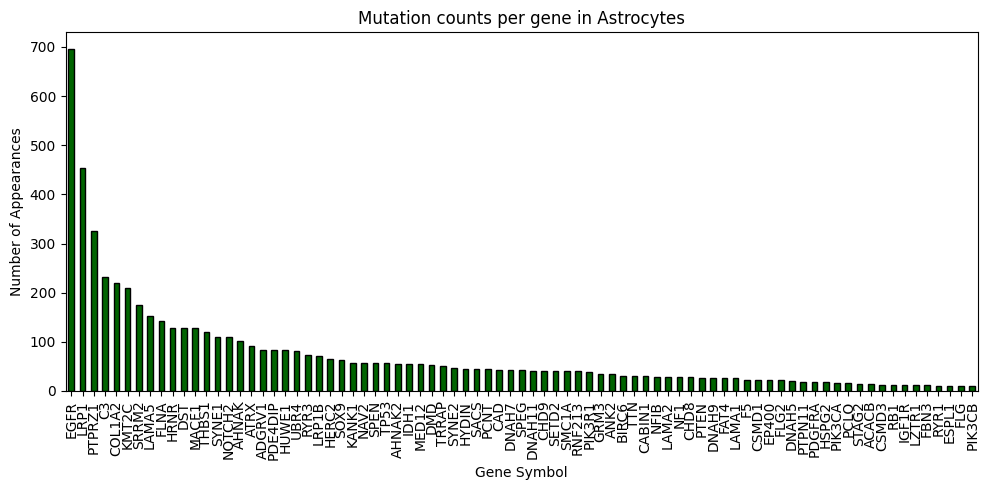

In [26]:
gene_counts = adata_astrocytes_filtered.var["gene_symbol"].value_counts()

print(f"Number of variants: {len(adata_astrocytes_filtered)}")
print(f"Number of genes: {len(adata_astrocytes_filtered.var['gene_symbol'].unique())}")


plt.figure(figsize=(10, 5))
gene_counts_filtered = gene_counts[gene_counts > 10]
gene_counts_filtered.plot(kind="bar", color="darkgreen", edgecolor="black")

plt.ylabel("Number of Appearances")
plt.xlabel("Gene Symbol")
plt.title("Mutation counts per gene in Astrocytes")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Number of variants: 88
Number of genes: 92


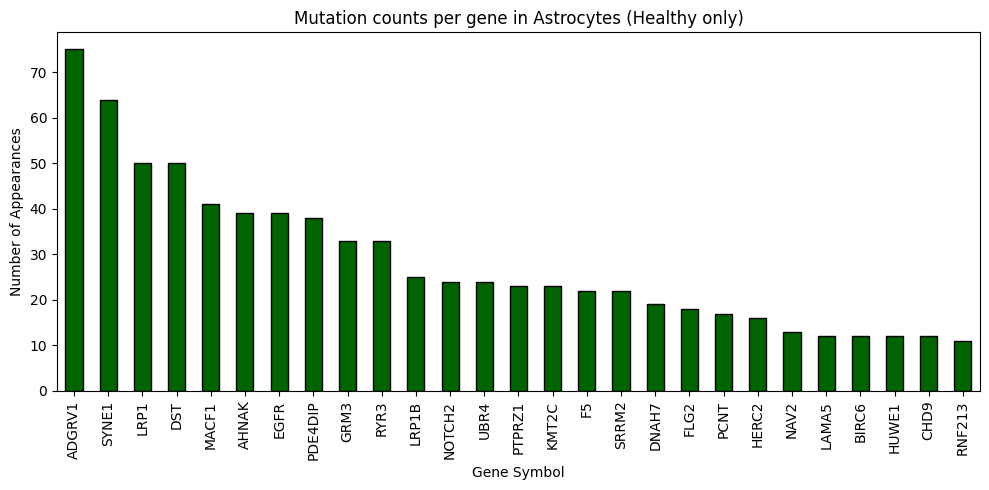

In [27]:
# repeat of above but just for healthy
adata_astrocytes_filtered_healthy_only = adata_astrocytes_filtered[adata_astrocytes_filtered.obs['cell_type_broad'] == "Astrocytes"].copy()

# Create mask: keep rows where at least one of the counts is > 0
mask = ~(adata_astrocytes_filtered_healthy_only.var["number_obs_healthy_astrocyte"] == 0)
adata_astrocytes_filtered_healthy_only = adata_astrocytes_filtered_healthy_only[:, mask].copy()

gene_counts_heatlhy_astrocyte_only = adata_astrocytes_filtered_healthy_only.var["gene_symbol"].value_counts()
print(f"Number of variants: {len(adata_astrocytes_filtered_healthy_only)}")
print(f"Number of genes: {len(adata_astrocytes_filtered_healthy_only.var['gene_symbol'].unique())}")


plt.figure(figsize=(10, 5))
gene_counts_filtered_healthy_astrocyte_only = gene_counts_heatlhy_astrocyte_only[gene_counts_heatlhy_astrocyte_only > 10]
gene_counts_filtered_healthy_astrocyte_only.plot(kind="bar", color="darkgreen", edgecolor="black")

plt.ylabel("Number of Appearances")
plt.xlabel("Gene Symbol")
plt.title("Mutation counts per gene in Astrocytes (Healthy only)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
adata_astrocytes_filtered.var.sort_values(by="VCCF_neoplastic_astrocyte_to_VCCF_healthy_astrocyte_ratio_1p", ascending=False).to_csv(os.path.join(out_dir, "Astrocytes_filtered.csv"), sep="\t")
adata_astrocytes_filtered.var.sort_values(by="VCCF_neoplastic_astrocyte_to_VCCF_healthy_astrocyte_ratio_1p", ascending=False).head(100)

,variant_name,gene_symbol,variant_count,gene_count,number_obs,VCCF,ROLE_IN_CANCER,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,gene_id,variant_name_with_gene_id,variant_name_with_gene_name,number_obs_neoplastic_astrocyte,number_obs_healthy_astrocyte,VCCF_neoplastic_astrocyte,VCCF_healthy_astrocyte,VCCF_neoplastic_astrocyte_to_VCCF_healthy_astrocyte_ratio,number_obs_neoplastic_astrocyte_1p,number_obs_healthy_astrocyte_1p,VCCF_neoplastic_astrocyte_1p,VCCF_healthy_astrocyte_1p,VCCF_neoplastic_astrocyte_to_VCCF_healthy_astrocyte_ratio_1p
31461,ENST00000245907:c.1005G>A,C3,54420.0,692,466,0.129841,NaN,NaN,NaN,ENST00000245907,c.1005G>A,1005,G>A,1005.0,1005.0,ENSG00000125730,ENSG00000125730(ENST00000245907):c.1005G>A,C3(ENST00000245907):c.1005G>A,151,0,0.138405,0.000000,inf,152,1,0.139322,0.011364,12.260312
261352,ENST00000297268:c.2116C>G,COL1A2,3906.0,304,163,0.045417,NaN,NaN,NaN,ENST00000297268,c.2116C>G,2116,C>G,2116.0,2116.0,ENSG00000164692,ENSG00000164692(ENST00000297268):c.2116C>G,COL1A2(ENST00000297268):c.2116C>G,142,0,0.130156,0.000000,inf,143,1,0.131072,0.011364,11.534372
223247,ENST00000260356:c.1732A>G,THBS1,51535.0,298,548,0.152689,NaN,NaN,NaN,ENST00000260356,c.1732A>G,1732,A>G,1732.0,1732.0,ENSG00000137801,ENSG00000137801(ENST00000260356):c.1732A>G,THBS1(ENST00000260356):c.1732A>G,123,0,0.112741,0.000000,inf,124,1,0.113657,0.011364,10.001833
223380,ENST00000260356:c.1575C>T,THBS1,39030.0,298,538,0.149902,NaN,NaN,NaN,ENST00000260356,c.1575C>T,1575,C>T,1575.0,1575.0,ENSG00000137801,ENSG00000137801(ENST00000260356):c.1575C>T,THBS1(ENST00000260356):c.1575C>T,121,0,0.110907,0.000000,inf,122,1,0.111824,0.011364,9.840513
223246,ENST00000260356:c.1455G>A,THBS1,19158.0,298,186,0.051825,NaN,NaN,NaN,ENST00000260356,c.1455G>A,1455,G>A,1455.0,1455.0,ENSG00000137801,ENSG00000137801(ENST00000260356):c.1455G>A,THBS1(ENST00000260356):c.1455G>A,116,0,0.106324,0.000000,inf,117,1,0.107241,0.011364,9.437214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11343,ENST00000405460:c.3237A>G,ADGRV1,212.0,84,7,0.00195,NaN,NaN,NaN,ENST00000405460,c.3237A>G,3237,A>G,3237.0,3237.0,ENSG00000164199,ENSG00000164199(ENST00000405460):c.3237A>G,ADGRV1(ENST00000405460):c.3237A>G,0,7,0.000000,0.079545,0.000000,1,8,0.000917,0.090909,0.010082
11339,ENST00000405460:c.7302G>A,ADGRV1,1270.0,84,35,0.009752,NaN,NaN,NaN,ENST00000405460,c.7302G>A,7302,G>A,7302.0,7302.0,ENSG00000164199,ENSG00000164199(ENST00000405460):c.7302G>A,ADGRV1(ENST00000405460):c.7302G>A,3,32,0.002750,0.363636,0.007562,4,33,0.003666,0.375000,0.009777
11337,ENST00000405460:c.3287A>C,ADGRV1,133.0,84,9,0.002508,NaN,NaN,NaN,ENST00000405460,c.3287A>C,3287,A>C,3287.0,3287.0,ENSG00000164199,ENSG00000164199(ENST00000405460):c.3287A>C,ADGRV1(ENST00000405460):c.3287A>C,0,9,0.000000,0.102273,0.000000,1,10,0.000917,0.113636,0.008066
11378,ENST00000405460:c.7130A>G,ADGRV1,453.0,84,18,0.005015,NaN,NaN,NaN,ENST00000405460,c.7130A>G,7130,A>G,7130.0,7130.0,ENSG00000164199,ENSG00000164199(ENST00000405460):c.7130A>G,ADGRV1(ENST00000405460):c.7130A>G,0,18,0.000000,0.204545,0.000000,1,19,0.000917,0.215909,0.004245


In [ ]:
adata_astrocytes_filtered.var.loc[(adata_astrocytes_filtered.var["gene_symbol"].isin(["EGFR", "SOX9"])) & ((adata_astrocytes_filtered.var["number_obs_neoplastic_astrocyte_1p"] > 1) | (adata_astrocytes_filtered.var["number_obs_healthy_astrocyte_1p"] > 1))].sort_values(by="VCCF_neoplastic_astrocyte_to_VCCF_healthy_astrocyte_ratio_1p", ascending=True).head(100)

,variant_name,gene_symbol,variant_count,gene_count,number_obs,VCCF,ROLE_IN_CANCER,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,gene_id,variant_name_with_gene_id,variant_name_with_gene_name,number_obs_neoplastic_astrocyte,number_obs_healthy_astrocyte,VCCF_neoplastic_astrocyte,VCCF_healthy_astrocyte,VCCF_neoplastic_astrocyte_to_VCCF_healthy_astrocyte_ratio,number_obs_neoplastic_astrocyte_1p,number_obs_healthy_astrocyte_1p,VCCF_neoplastic_astrocyte_1p,VCCF_healthy_astrocyte_1p,VCCF_neoplastic_astrocyte_to_VCCF_healthy_astrocyte_ratio_1p
285488,ENST00000245479:c.429C>T,SOX9,2.0,69,1,0.000279,NaN,NaN,NaN,ENST00000245479,c.429C>T,429,C>T,429.0,429.0,ENSG00000125398,ENSG00000125398(ENST00000245479):c.429C>T,SOX9(ENST00000245479):c.429C>T,0,1,0.000000,0.011364,0.0,1,2,0.000917,0.022727,0.040330
357787,ENST00000275493:c.2434C>T,EGFR,2.0,703,1,0.000279,oncogene,"glioma, NSCLC",NSCLC,ENST00000275493,c.2434C>T,2434,C>T,2434.0,2434.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.2434C>T,EGFR(ENST00000275493):c.2434C>T,0,1,0.000000,0.011364,0.0,1,2,0.000917,0.022727,0.040330
285505,ENST00000245479:c.793A>G,SOX9,4.0,69,1,0.000279,NaN,NaN,NaN,ENST00000245479,c.793A>G,793,A>G,793.0,793.0,ENSG00000125398,ENSG00000125398(ENST00000245479):c.793A>G,SOX9(ENST00000245479):c.793A>G,0,1,0.000000,0.011364,0.0,1,2,0.000917,0.022727,0.040330
285477,ENST00000245479:c.630G>A,SOX9,2.0,69,1,0.000279,NaN,NaN,NaN,ENST00000245479,c.630G>A,630,G>A,630.0,630.0,ENSG00000125398,ENSG00000125398(ENST00000245479):c.630G>A,SOX9(ENST00000245479):c.630G>A,0,1,0.000000,0.011364,0.0,1,2,0.000917,0.022727,0.040330
357596,ENST00000275493:c.1555G>A,EGFR,16.0,703,1,0.000279,oncogene,"glioma, NSCLC",NSCLC,ENST00000275493,c.1555G>A,1555,G>A,1555.0,1555.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.1555G>A,EGFR(ENST00000275493):c.1555G>A,0,1,0.000000,0.011364,0.0,1,2,0.000917,0.022727,0.040330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357937,ENST00000275493:c.2557C>T,EGFR,132.0,703,33,0.009195,oncogene,"glioma, NSCLC",NSCLC,ENST00000275493,c.2557C>T,2557,C>T,2557.0,2557.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.2557C>T,EGFR(ENST00000275493):c.2557C>T,33,0,0.030247,0.000000,inf,34,1,0.031164,0.011364,2.742438
357653,ENST00000275493:c.1608G>A,EGFR,539.0,703,37,0.010309,oncogene,"glioma, NSCLC",NSCLC,ENST00000275493,c.1608G>A,1608,G>A,1608.0,1608.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.1608G>A,EGFR(ENST00000275493):c.1608G>A,36,0,0.032997,0.000000,inf,37,1,0.033914,0.011364,2.984418
285462,ENST00000245479:c.1875C>T,SOX9,821.0,69,44,0.01226,NaN,NaN,NaN,ENST00000245479,c.1875C>T,1875,C>T,1875.0,1875.0,ENSG00000125398,ENSG00000125398(ENST00000245479):c.1875C>T,SOX9(ENST00000245479):c.1875C>T,42,0,0.038497,0.000000,inf,43,1,0.039413,0.011364,3.468378
358038,ENST00000275493:c.2348G>A,EGFR,129.0,703,47,0.013096,oncogene,"glioma, NSCLC",NSCLC,ENST00000275493,c.2348G>A,2348,G>A,2348.0,2348.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.2348G>A,EGFR(ENST00000275493):c.2348G>A,43,0,0.039413,0.000000,inf,44,1,0.040330,0.011364,3.549038


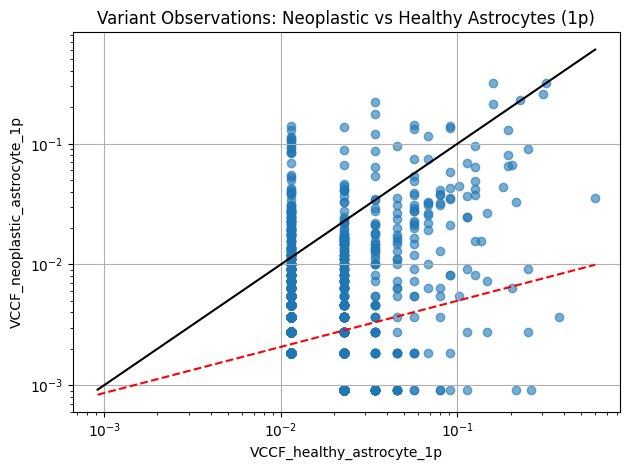

In [30]:
import matplotlib.pyplot as plt

x = adata_astrocytes_filtered.var['VCCF_healthy_astrocyte_1p']
y = adata_astrocytes_filtered.var['VCCF_neoplastic_astrocyte_1p']

mask = (x > 0) & (y > 0)
x_log = np.log10(x[mask])
y_log = np.log10(y[mask])

# Reference line y = x
lims = [min(x.min(), y.min()), max(x.max(), y.max())]
plt.plot(lims, lims, 'k-', label='y = x')  # solid black line

# Best-fit line
slope, intercept = np.polyfit(x_log, y_log, 1)
x_fit_log = np.log10(np.array(lims))
y_fit_log = slope * x_fit_log + intercept

x_fit = 10**x_fit_log
y_fit = 10**y_fit_log
plt.plot(x_fit, y_fit, 'r--', label='Best-fit (log-log)')  # best-fit line


plt.scatter(x, y, alpha=0.6)
plt.xlabel("VCCF_healthy_astrocyte_1p")
plt.ylabel("VCCF_neoplastic_astrocyte_1p")
plt.xscale('log')
plt.yscale('log')
plt.title("Variant Observations: Neoplastic vs Healthy Astrocytes (1p)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# look between neoplastic clusters
adata_astrocytes_filtered_neoplastic_only = adata_astrocytes_filtered[adata_astrocytes_filtered.obs['cell_type_broad'] == "Neoplastic cells"].copy()

# 1
mask_neoplastic_1 = (adata_astrocytes_filtered_neoplastic_only.obs["cell_type"] == "Neoplastic cells 1").values
nonzero_counts_1 = (adata_astrocytes_filtered_neoplastic_only.X[mask_neoplastic_1] > 0).sum(axis=0)
nonzero_counts_1 = nonzero_counts_1.A1 if hasattr(nonzero_counts_1, "A1") else np.array(nonzero_counts_1).ravel()
adata_astrocytes_filtered_neoplastic_only.var["number_obs_neoplastic_astrocyte_1"] = nonzero_counts_1
adata_astrocytes_filtered_neoplastic_only.var["VCCF_neoplastic_astrocyte_1"] = adata_astrocytes_filtered_neoplastic_only.var["number_obs_neoplastic_astrocyte_1"] / cell_type_counts["Neoplastic cells"]
adata_astrocytes_filtered_neoplastic_only.var["number_obs_neoplastic_astrocyte_1p_1"] = adata_astrocytes_filtered_neoplastic_only.var["number_obs_neoplastic_astrocyte_1"] + 1
adata_astrocytes_filtered_neoplastic_only.var["VCCF_neoplastic_astrocyte_1p_1"] = adata_astrocytes_filtered_neoplastic_only.var["number_obs_neoplastic_astrocyte_1p_1"] / (cell_type_counts["Neoplastic cells"])

# 2
mask_neoplastic_2 = (adata_astrocytes_filtered_neoplastic_only.obs["cell_type"] == "Neoplastic cells 2").values
nonzero_counts_2 = (adata_astrocytes_filtered_neoplastic_only.X[mask_neoplastic_2] > 0).sum(axis=0)
nonzero_counts_2 = nonzero_counts_2.A1 if hasattr(nonzero_counts_2, "A1") else np.array(nonzero_counts_2).ravel()
adata_astrocytes_filtered_neoplastic_only.var["number_obs_neoplastic_astrocyte_2"] = nonzero_counts_2
adata_astrocytes_filtered_neoplastic_only.var["VCCF_neoplastic_astrocyte_2"] = adata_astrocytes_filtered_neoplastic_only.var["number_obs_neoplastic_astrocyte_2"] / cell_type_counts["Neoplastic cells"]
adata_astrocytes_filtered_neoplastic_only.var["number_obs_neoplastic_astrocyte_1p_2"] = adata_astrocytes_filtered_neoplastic_only.var["number_obs_neoplastic_astrocyte_2"] + 1
adata_astrocytes_filtered_neoplastic_only.var["VCCF_neoplastic_astrocyte_1p_2"] = adata_astrocytes_filtered_neoplastic_only.var["number_obs_neoplastic_astrocyte_1p_2"] / (cell_type_counts["Neoplastic cells"])

# 3
mask_neoplastic_3 = (adata_astrocytes_filtered_neoplastic_only.obs["cell_type"] == "Neoplastic cells 3").values
nonzero_counts_3 = (adata_astrocytes_filtered_neoplastic_only.X[mask_neoplastic_3] > 0).sum(axis=0)
nonzero_counts_3 = nonzero_counts_3.A1 if hasattr(nonzero_counts_3, "A1") else np.array(nonzero_counts_3).ravel()
adata_astrocytes_filtered_neoplastic_only.var["number_obs_neoplastic_astrocyte_3"] = nonzero_counts_3
adata_astrocytes_filtered_neoplastic_only.var["VCCF_neoplastic_astrocyte_3"] = adata_astrocytes_filtered_neoplastic_only.var["number_obs_neoplastic_astrocyte_3"] / cell_type_counts["Neoplastic cells"]
adata_astrocytes_filtered_neoplastic_only.var["number_obs_neoplastic_astrocyte_1p_3"] = adata_astrocytes_filtered_neoplastic_only.var["number_obs_neoplastic_astrocyte_3"] + 1
adata_astrocytes_filtered_neoplastic_only.var["VCCF_neoplastic_astrocyte_1p_3"] = adata_astrocytes_filtered_neoplastic_only.var["number_obs_neoplastic_astrocyte_1p_3"] / (cell_type_counts["Neoplastic cells"])

def make_scatterplot(adata, x_column, y_column, log_scale=False):
    x = adata.var[x_column]
    y = adata.var[y_column]

    # Reference line y = x
    lims = [min(x.min(), y.min()), max(x.max(), y.max())]
    plt.plot(lims, lims, 'k-', label='y = x')  # solid black line

    # if log_scale:
    #     mask = (x > 0) & (y > 0)
    #     x_regression = np.log10(x[mask])
    #     y_regression = np.log10(y[mask])
    # else:
    #     x_regression = x
    #     y_regression = y

    # # Best-fit line
    # slope, intercept = np.polyfit(x_regression, y_regression, 1)
    # x_fit = np.log10(np.array(lims))
    # y_fit = slope * x_fit + intercept

    # if log_scale:
    #     x_fit = 10**x_fit
    #     y_fit = 10**y_fit
    # plt.plot(x_fit, y_fit, 'r--', label='Best-fit')  # best-fit line

    plt.scatter(x, y, alpha=0.6)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    if log_scale:
        plt.xscale('log')
        plt.yscale('log')
    plt.title(f"Variant Observations: {y_column} vs {x_column} (1p)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

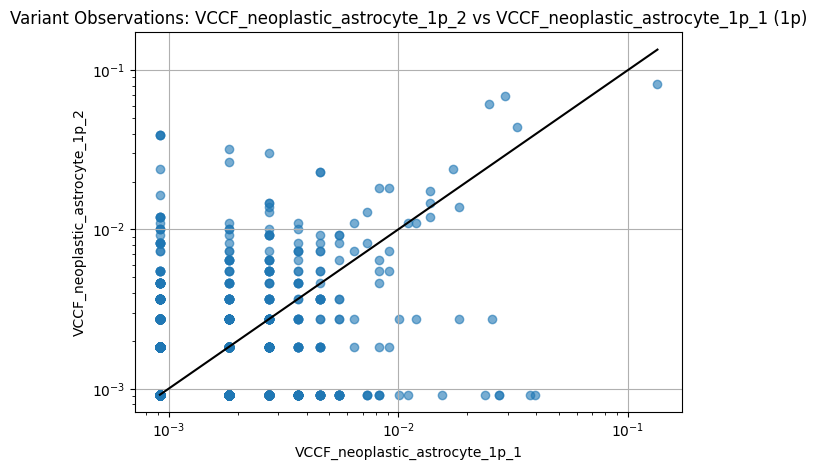

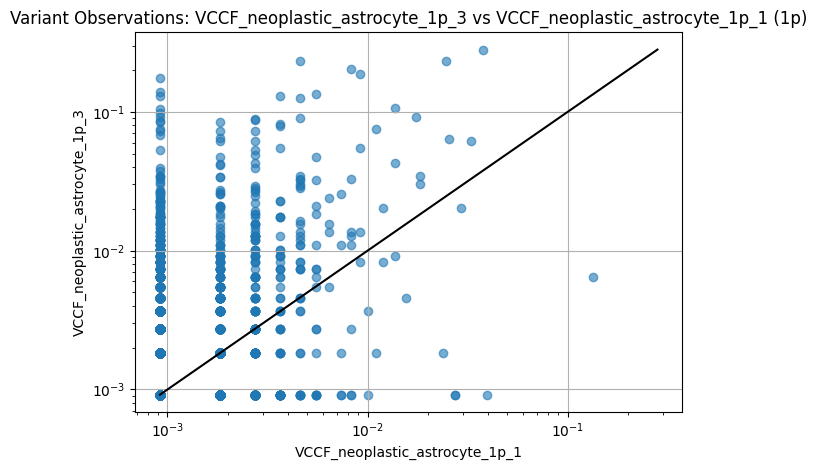

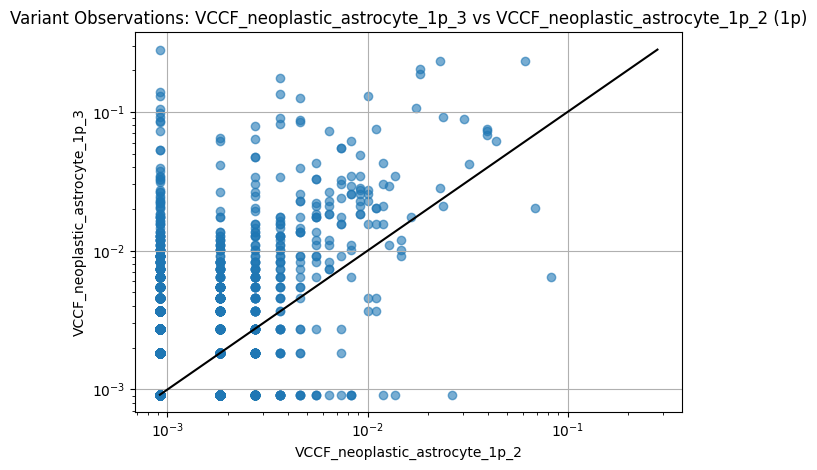

In [74]:
make_scatterplot(adata_astrocytes_filtered_neoplastic_only, x_column="VCCF_neoplastic_astrocyte_1p_1", y_column="VCCF_neoplastic_astrocyte_1p_2", log_scale=True)
make_scatterplot(adata_astrocytes_filtered_neoplastic_only, x_column="VCCF_neoplastic_astrocyte_1p_1", y_column="VCCF_neoplastic_astrocyte_1p_3", log_scale=True)
make_scatterplot(adata_astrocytes_filtered_neoplastic_only, x_column="VCCF_neoplastic_astrocyte_1p_2", y_column="VCCF_neoplastic_astrocyte_1p_3", log_scale=True)

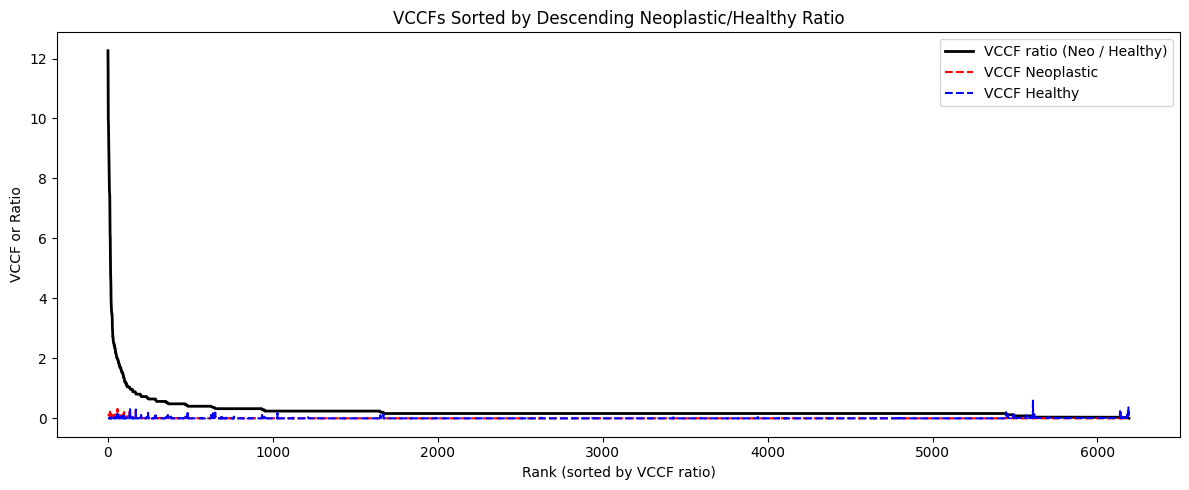

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Get a DataFrame of all three VCCFs, dropping NaNs
df = adata_astrocytes_filtered.var[[
    "VCCF_neoplastic_astrocyte_to_VCCF_healthy_astrocyte_ratio_1p",
    "VCCF_neoplastic_astrocyte",
    "VCCF_healthy_astrocyte"
]].dropna()

# Sort by ratio descending
df_sorted = df.sort_values(by="VCCF_neoplastic_astrocyte_to_VCCF_healthy_astrocyte_ratio_1p", ascending=False)

# Extract values
ratios_sorted = df_sorted["VCCF_neoplastic_astrocyte_to_VCCF_healthy_astrocyte_ratio_1p"].values
neoplastic_sorted = df_sorted["VCCF_neoplastic_astrocyte"].values
healthy_sorted = df_sorted["VCCF_healthy_astrocyte"].values

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ratios_sorted, label="VCCF ratio (Neo / Healthy)", color="black", linewidth=2)
plt.plot(neoplastic_sorted, label="VCCF Neoplastic", color="red", linestyle="--")
plt.plot(healthy_sorted, label="VCCF Healthy", color="blue", linestyle="--")

plt.xlabel("Rank (sorted by VCCF ratio)")
plt.ylabel("VCCF or Ratio")
plt.title("VCCFs Sorted by Descending Neoplastic/Healthy Ratio")
plt.legend()
plt.tight_layout()
plt.show()


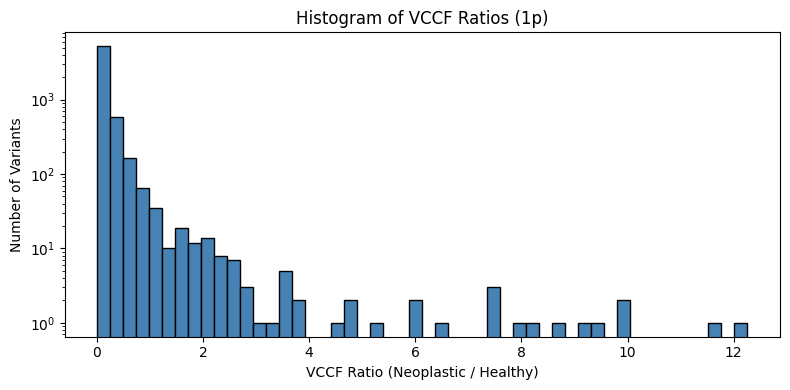

In [32]:
plt.figure(figsize=(8, 4))
plt.hist(ratios_sorted, bins=50, color='steelblue', edgecolor='black')
plt.xlabel("VCCF Ratio (Neoplastic / Healthy)")
plt.ylabel("Number of Variants")
# plt.xscale('log')
plt.yscale('log')
plt.title("Histogram of VCCF Ratios (1p)")
plt.tight_layout()
plt.show()

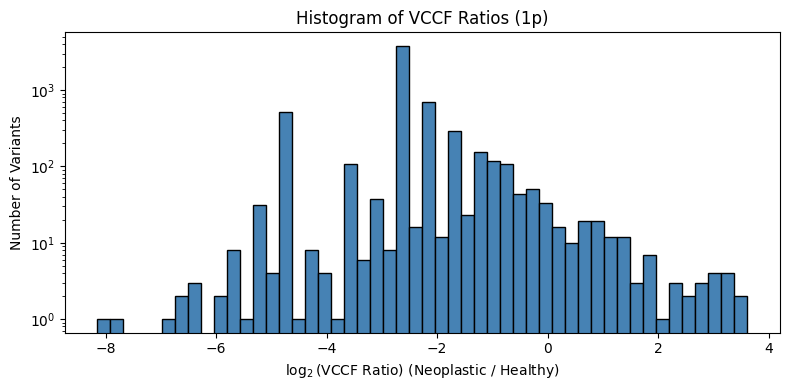

In [33]:
import math
log_ratios = [math.log2(x) for x in ratios_sorted]

plt.figure(figsize=(8, 4))
plt.hist(log_ratios, bins=50, color='steelblue', edgecolor='black')
plt.xlabel(r"$\log_{2}(\mathrm{VCCF\ Ratio)\ (Neoplastic\ /\ Healthy)}$")
plt.ylabel("Number of Variants")
plt.yscale('log')
plt.title("Histogram of VCCF Ratios (1p)")
plt.tight_layout()

plt.savefig(os.path.join(out_dir, "histogram_vaf_ratios_1p.png"), dpi=300)
plt.show()

Number of variants with VCCF ratio >= 2.1: 51
Number of genes with VCCF ratio >= 2.1: 13


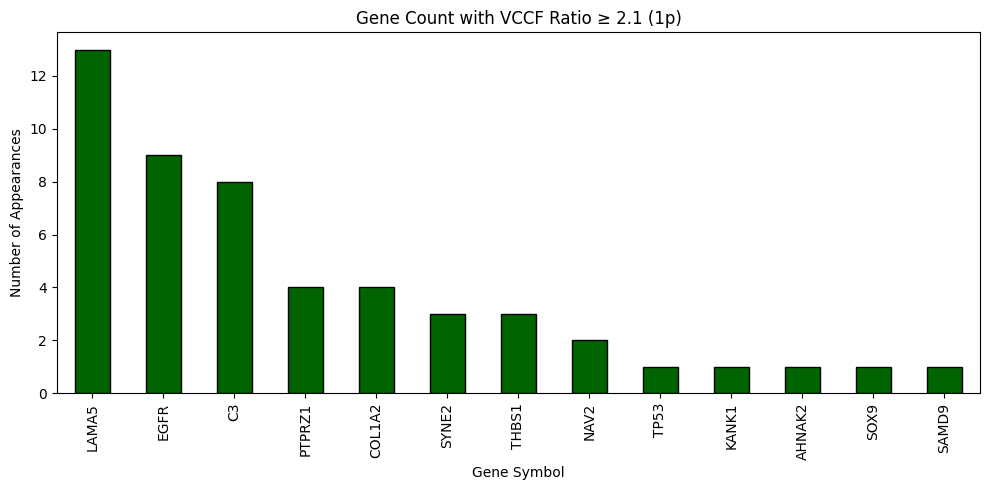

In [34]:
VCCF_ratio_cutoff = 2.1

# Step 1: Filter
filtered_df = adata_astrocytes.var[
    adata_astrocytes.var["VCCF_neoplastic_astrocyte_to_VCCF_healthy_astrocyte_ratio_1p"] >= VCCF_ratio_cutoff
]

# Step 2: Count gene_symbol occurrences
gene_counts = filtered_df["gene_symbol"].value_counts()

print(f"Number of variants with VCCF ratio >= {VCCF_ratio_cutoff}: {len(filtered_df)}")
print(f"Number of genes with VCCF ratio >= {VCCF_ratio_cutoff}: {len(gene_counts)}")

# Step 3: Sort descending (already sorted by default from value_counts)

# Step 4: Bar plot
plt.figure(figsize=(10, 5))
gene_counts.plot(kind="bar", color="darkgreen", edgecolor="black")

plt.ylabel("Number of Appearances")
plt.xlabel("Gene Symbol")
plt.title(f"Gene Count with VCCF Ratio ≥ {VCCF_ratio_cutoff} (1p)")
plt.xticks(rotation=90)
plt.tight_layout()

plt.savefig(os.path.join(out_dir, "gene_counts.png"), dpi=300)
plt.show()


In [35]:
print(f"EGFR/SOX9 = {gene_counts['EGFR']}/{gene_counts['SOX9']} = {gene_counts['EGFR'] / gene_counts['SOX9']:.2f}")

EGFR/SOX9 = 9/1 = 9.00


More than the 2.4 represented in COSMIC

## Total mutational burden in astrocytes

# Histograms

In [36]:
adata.obs.head()

,Run,experiment_name,cell_type_sra,neoplastic,Patient_ID,tissue,tsne_cluster,cell_type,cell_type_broad
barcode,,,,,,,,,
AAAAAAAAAAAAAAAA,SRR3934349,1001000173.G8,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAAAC,SRR3934350,1001000173.D4,Oligodendrocyte,Regular,BT_S2,Tumor,2,Oligodendrocytes,Oligodendrocytes
AAAAAAAAAAAAAAAG,SRR3934351,1001000173.B4,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAAAT,SRR3934352,1001000173.A2,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAACA,SRR3934353,1001000173.E2,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells


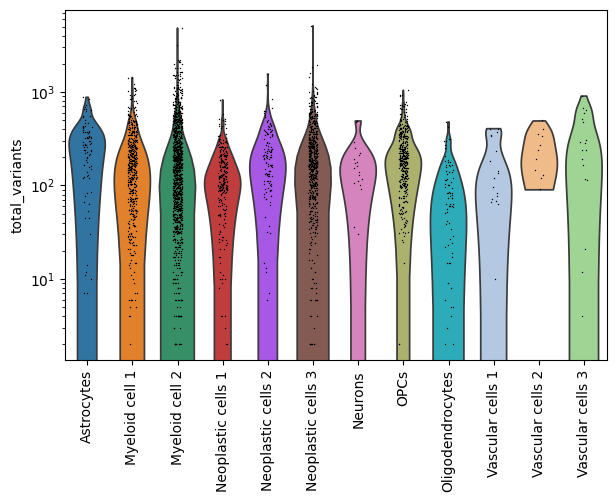

In [37]:
total_variants = adata.X.sum(axis=1).A1 if hasattr(adata.X, "A1") else np.ravel(adata.X.sum(axis=1))
adata.obs["total_variants"] = total_variants
sc.pl.violin(adata, keys='total_variants', groupby='cell_type', rotation=90, log=True)

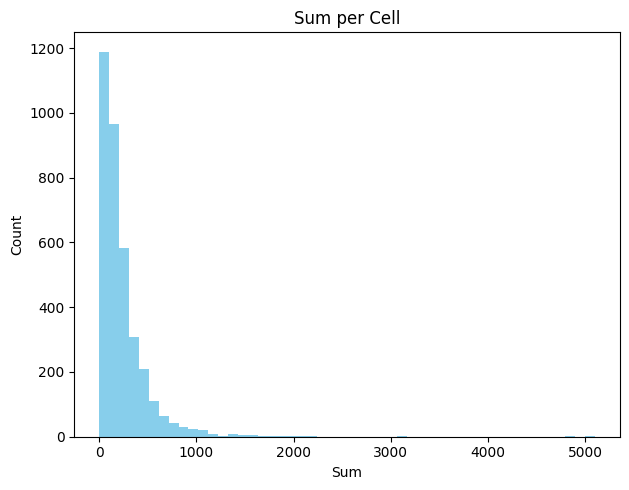

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Sum across rows (total variant counts per cell)
row_sums = adata.X.sum(axis=1).A1 if hasattr(adata.X, "A1") else np.ravel(adata.X.sum(axis=1))

# Sum across columns (total counts across all cells per variant)
col_sums = adata.X.sum(axis=0).A1 if hasattr(adata.X, "A1") else np.ravel(adata.X.sum(axis=0))

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(row_sums, bins=50, color='skyblue')
plt.title('Sum per Cell')
plt.xlabel('Sum')
plt.ylabel('Count')

# plt.subplot(1, 2, 2)
# plt.hist(col_sums, bins=50, color='salmon')
# plt.title('Sum per Gene')
# plt.xlabel('Sum')
# plt.ylabel('Count')

plt.tight_layout()
plt.show()


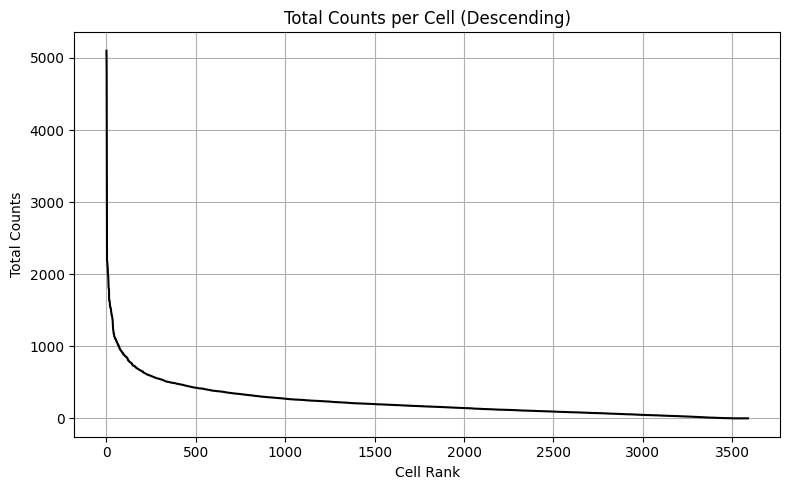

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Compute sum per cell (rows)
row_sums = adata.X.sum(axis=1).A1 if hasattr(adata.X, "A1") else np.ravel(adata.X.sum(axis=1))

# Sort descending
sorted_sums = np.sort(row_sums)[::-1]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(sorted_sums, color='black')
plt.title("Total Counts per Cell (Descending)")
plt.xlabel("Cell Rank")
plt.ylabel("Total Counts")
plt.grid(True)
plt.tight_layout()
plt.show()


## assign oncogene vs tumor suppressor gene - I expect oncogenes to be more prevelant in mutation data

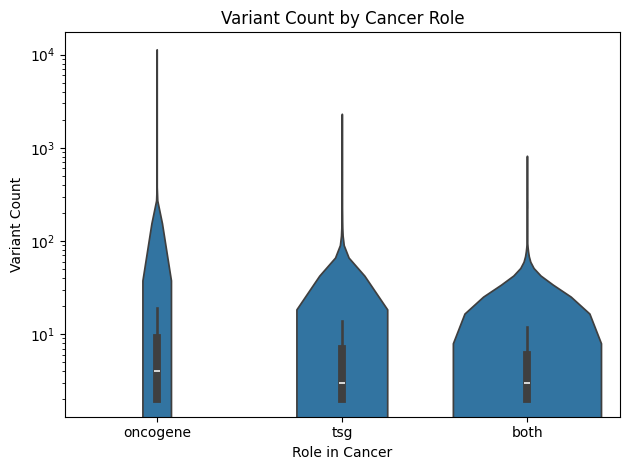

In [40]:
# Copy the column and drop NaNs
role = adata.var['ROLE_IN_CANCER'].dropna().copy()

# Map to simplified categories
def simplify_role(val):
    val = val.lower()
    if 'oncogene' in val and 'tsg' in val:
        return 'both'
    elif 'oncogene' in val:
        return 'oncogene'
    elif 'tsg' in val:
        return 'tsg'
    else:
        return None  # optional: keep only known roles

adata.var['simplified_role'] = role.apply(simplify_role)
tumor_role_df = adata.var.dropna(subset=['simplified_role', 'variant_count'])

import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(data=tumor_role_df, x='simplified_role', y='variant_count', order=['oncogene', 'tsg', 'both'])
plt.xlabel("Role in Cancer")
plt.ylabel("Variant Count")
plt.yscale('log')
plt.title("Variant Count by Cancer Role")
plt.tight_layout()
plt.show()


In [41]:
adata.var.head()

,variant_name,gene_symbol,variant_count,gene_count,number_obs,VCCF,ROLE_IN_CANCER,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,gene_id,variant_name_with_gene_id,variant_name_with_gene_name,simplified_role
679,ENST00000256646:c.847C>T,NOTCH2,2.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.847C>T,847,C>T,847.0,847.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.847C>T,NOTCH2(ENST00000256646):c.847C>T,both
680,ENST00000256646:c.7169C>T,NOTCH2,3.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.7169C>T,7169,C>T,7169.0,7169.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.7169C>T,NOTCH2(ENST00000256646):c.7169C>T,both
681,ENST00000256646:c.6314C>T,NOTCH2,2.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.6314C>T,6314,C>T,6314.0,6314.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.6314C>T,NOTCH2(ENST00000256646):c.6314C>T,both
682,ENST00000256646:c.5768G>A,NOTCH2,2.0,189,1,0.000279,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.5768G>A,5768,G>A,5768.0,5768.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.5768G>A,NOTCH2(ENST00000256646):c.5768G>A,both
683,ENST00000256646:c.634A>T,NOTCH2,6.0,189,3,0.000836,"oncogene, TSG","marginal zone lymphoma, DLBCL, bladder",NaN,ENST00000256646,c.634A>T,634,A>T,634.0,634.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.634A>T,NOTCH2(ENST00000256646):c.634A>T,both


## Alphafold

### Let's hand-pick some of the top mutations
- ENST00000245907:c.1005G>A  # C3 - 151 neoplastic, 0 healthy
- ENST00000297268:c.2116C>G  # COL1A2 - 142 neoplastic, 0 healthy
- ENST00000260356:c.1732A>G  # THBS1 - 123 neoplastic, 0 healthy
- ENST00000260356:c.1575C>T  # THBS1 - 121 neoplastic, 0 healthy
- ENST00000297268:c.2349G>T  # COL1A2 - 114 neoplastic, 0 healthy
- ENST00000245907:c.2514G>C  # C3 - 107 neoplastic, 0 healthy
- ENST00000252999:c.2194A>G  # COL1A2 - 101 neoplastic, 0 healthy
- ENST00000275493:c.1782C>T  # EGFR - 44 neoplastic, 0 healthy
- ENST00000275493:c.2348G>A  # EGFR - 43 neoplastic, 0 healthy
- ENST00000245479:c.1875C>T  # SOX9 - 42 neoplastic, 0 healthy

- ENST00000245479:c.429C>T  # SOX9, 0 neoplastic, 1 healthy (negative control)
- ENST00000275493:c.2434C>T  # EGFR, 0 neoplastic, 1 healthy (negative control)

In [42]:
print(cosmic_df.head(1))

            seq_ID   mutation mutation_aa gene_name  mutation_id  \
0  ENST00000396153  c.1468C>T     p.Q490*      FAF1     48293736   

  mutation_cdna                     header  
0     c.1920C>T  ENST00000396153:c.1920C>T  


In [43]:
import os
import varseek as vk
import pyfastx
import tempfile

hgvs_list = [
    "ENST00000245907:c.1005G>A",
    "ENST00000297268:c.2116C>G",
    "ENST00000260356:c.1732A>G",
    "ENST00000260356:c.1575C>T",
    "ENST00000297268:c.2349G>T",
    "ENST00000245907:c.2514G>C",
    "ENST00000252999:c.2194A>G",
    "ENST00000275493:c.1782C>T",
    "ENST00000275493:c.2348G>A",
    "ENST00000245479:c.1875C>T",
    "ENST00000245479:c.429C>T",
    "ENST00000275493:c.2434C>T",
]

setup_alphafold = False

if setup_alphafold:
    gget.setup('alphafold')

cds_fasta = pyfastx.Fasta(sequences_cds, build_index=True)

id_map = {}
for name in cds_fasta.keys():
    clean_id = name.split('.')[0]
    id_map[clean_id] = name

rows = []

alphafold_out_dir = os.path.join(out_dir, "alphafold_predictions")
os.makedirs(alphafold_out_dir, exist_ok=True)
for hgvs in hgvs_list:
    transcript_id, variant_cdna = hgvs.split(":")
    row = cosmic_df.loc[cosmic_df["header"] == hgvs, ["mutation_aa", "mutation", "gene_name", "seq_ID"]].iloc[0]
    mutation_aa, variant_cds, gene_name, transcript_id = row["mutation_aa"], row["mutation"], row["gene_name"], row["seq_ID"]
    hgvs_cds = f"{transcript_id}:{variant_cds}"
    if mutation_aa is None:
        print(f"Mutation {hgvs} not found in cosmic_df")
    
    print(f"{gene_name} {hgvs_cds}: {mutation_aa}")

    wt_sequence_nucleotide = cds_fasta[id_map[transcript_id]].seq
    
    with tempfile.TemporaryDirectory() as tmp_dir:
        variant_sequence_nucleotide = vk.build(variants=variant_cds, sequences=wt_sequence_nucleotide, w=999998, k=999999, max_ambiguous=None, min_seq_len=1, optimize_flanking_regions=False, remove_seqs_with_wt_kmers=False, required_insertion_overlap_length=None, merge_identical=False, return_variant_output=True, out=tmp_dir)[0]
    variant_sequence_amino_acid = vk.utils.translate_sequence(variant_sequence_nucleotide)
    variant_sequence_amino_acid = variant_sequence_amino_acid[:-1]  # remove stop codon

    wt_sequence_amino_acid = vk.utils.translate_sequence(wt_sequence_nucleotide)
    wt_sequence_amino_acid = wt_sequence_amino_acid[:-1]  # remove stop codon

    alphafold_row = {
        "hgvs": hgvs_cds,
        "hgvs_cdna": hgvs,
        "transcript_id": transcript_id,
        "gene_name": gene_name,
        "mutation_cds": variant_cds,
        "mutation_aa": mutation_aa,
        "sequence_wt_nucloeotide": str(wt_sequence_nucleotide),
        "sequence_mutant_nucleotide": str(variant_sequence_nucleotide),
        "sequence_wt_amino_acid": str(variant_sequence_amino_acid),
        "sequence_mutant_amino_acid": str(variant_sequence_amino_acid),
    }
    rows.append(alphafold_row)
    
    out_dir = os.path.join(alphafold_out_dir, gene_name, hgvs)
    os.makedirs(out_dir, exist_ok=True)
    # gget.alphafold(variant_sequence_amino_acid, out=out_dir, relax=True)

alphafold_df = pd.DataFrame(rows)

11:42:18 - WARNING - If running a workflow with vk ref or kb ref, k should be an odd number between 1 and 63. Got k=999999.
11:42:18 - INFO - Using COSMIC email from COSMIC_EMAIL environment variable: jmrich@caltech.edu
11:42:18 - INFO - Using COSMIC password from COSMIC_PASSWORD environment variable
11:42:18 - INFO - Using the seq_id_column:var_column 'seq_ID:mutation' columns as the variant header column.
11:42:18 - INFO - Removed 0 variant-containing reference sequences with length less than 1...
11:42:18 - INFO - All variants correctly recorded
11:42:18 - INFO - FASTA file containing VCRSs created at /tmp/tmpn6cnlwxx/vcrs.fa.
11:42:18 - INFO - t2g file containing VCRSs created at /tmp/tmpn6cnlwxx/vcrs_t2g.txt.
11:42:18 - INFO - Total runtime for vk build: 0m, 0.07s


C3 ENST00000245907:c.912G>A: p.R304=


11:42:19 - WARNING - If running a workflow with vk ref or kb ref, k should be an odd number between 1 and 63. Got k=999999.
11:42:19 - INFO - Using COSMIC email from COSMIC_EMAIL environment variable: jmrich@caltech.edu
11:42:19 - INFO - Using COSMIC password from COSMIC_PASSWORD environment variable
11:42:19 - INFO - Using the seq_id_column:var_column 'seq_ID:mutation' columns as the variant header column.
11:42:19 - INFO - Removed 0 variant-containing reference sequences with length less than 1...
11:42:19 - INFO - All variants correctly recorded
11:42:19 - INFO - FASTA file containing VCRSs created at /tmp/tmpptz111oi/vcrs.fa.
11:42:19 - INFO - t2g file containing VCRSs created at /tmp/tmpptz111oi/vcrs_t2g.txt.
11:42:19 - INFO - Total runtime for vk build: 0m, 0.07s


COL1A2 ENST00000297268:c.1645C>G: p.P549A


11:42:19 - WARNING - If running a workflow with vk ref or kb ref, k should be an odd number between 1 and 63. Got k=999999.
11:42:19 - INFO - Using COSMIC email from COSMIC_EMAIL environment variable: jmrich@caltech.edu
11:42:19 - INFO - Using COSMIC password from COSMIC_PASSWORD environment variable
11:42:19 - INFO - Using the seq_id_column:var_column 'seq_ID:mutation' columns as the variant header column.
11:42:20 - INFO - Removed 0 variant-containing reference sequences with length less than 1...
11:42:20 - INFO - All variants correctly recorded
11:42:20 - INFO - FASTA file containing VCRSs created at /tmp/tmp_if4ycfe/vcrs.fa.
11:42:20 - INFO - t2g file containing VCRSs created at /tmp/tmp_if4ycfe/vcrs_t2g.txt.
11:42:20 - INFO - Total runtime for vk build: 0m, 0.07s


THBS1 ENST00000260356:c.1567A>G: p.T523A


11:42:20 - WARNING - If running a workflow with vk ref or kb ref, k should be an odd number between 1 and 63. Got k=999999.
11:42:20 - INFO - Using COSMIC email from COSMIC_EMAIL environment variable: jmrich@caltech.edu
11:42:20 - INFO - Using COSMIC password from COSMIC_PASSWORD environment variable
11:42:20 - INFO - Using the seq_id_column:var_column 'seq_ID:mutation' columns as the variant header column.
11:42:20 - INFO - Removed 0 variant-containing reference sequences with length less than 1...
11:42:20 - INFO - All variants correctly recorded
11:42:20 - INFO - FASTA file containing VCRSs created at /tmp/tmp67u0p96b/vcrs.fa.
11:42:20 - INFO - t2g file containing VCRSs created at /tmp/tmp67u0p96b/vcrs_t2g.txt.
11:42:20 - INFO - Total runtime for vk build: 0m, 0.07s


THBS1 ENST00000260356:c.1410C>T: p.N470=


11:42:20 - WARNING - If running a workflow with vk ref or kb ref, k should be an odd number between 1 and 63. Got k=999999.
11:42:20 - INFO - Using COSMIC email from COSMIC_EMAIL environment variable: jmrich@caltech.edu
11:42:20 - INFO - Using COSMIC password from COSMIC_PASSWORD environment variable
11:42:20 - INFO - Using the seq_id_column:var_column 'seq_ID:mutation' columns as the variant header column.
11:42:21 - INFO - Removed 0 variant-containing reference sequences with length less than 1...
11:42:21 - INFO - All variants correctly recorded
11:42:21 - INFO - FASTA file containing VCRSs created at /tmp/tmp6r1w4zms/vcrs.fa.
11:42:21 - INFO - t2g file containing VCRSs created at /tmp/tmp6r1w4zms/vcrs_t2g.txt.
11:42:21 - INFO - Total runtime for vk build: 0m, 0.07s


COL1A2 ENST00000297268:c.1878G>T: p.V626=


11:42:21 - WARNING - If running a workflow with vk ref or kb ref, k should be an odd number between 1 and 63. Got k=999999.
11:42:21 - INFO - Using COSMIC email from COSMIC_EMAIL environment variable: jmrich@caltech.edu
11:42:21 - INFO - Using COSMIC password from COSMIC_PASSWORD environment variable
11:42:21 - INFO - Using the seq_id_column:var_column 'seq_ID:mutation' columns as the variant header column.
11:42:21 - INFO - Removed 0 variant-containing reference sequences with length less than 1...
11:42:21 - INFO - All variants correctly recorded
11:42:21 - INFO - FASTA file containing VCRSs created at /tmp/tmppw_7zt6l/vcrs.fa.
11:42:21 - INFO - t2g file containing VCRSs created at /tmp/tmppw_7zt6l/vcrs_t2g.txt.
11:42:21 - INFO - Total runtime for vk build: 0m, 0.07s


C3 ENST00000245907:c.2421G>C: p.V807=


11:42:22 - WARNING - If running a workflow with vk ref or kb ref, k should be an odd number between 1 and 63. Got k=999999.
11:42:22 - INFO - Using COSMIC email from COSMIC_EMAIL environment variable: jmrich@caltech.edu
11:42:22 - INFO - Using COSMIC password from COSMIC_PASSWORD environment variable
11:42:22 - INFO - Using the seq_id_column:var_column 'seq_ID:mutation' columns as the variant header column.
11:42:22 - INFO - Removed 0 variant-containing reference sequences with length less than 1...
11:42:22 - INFO - All variants correctly recorded
11:42:22 - INFO - FASTA file containing VCRSs created at /tmp/tmp0o8o7jbg/vcrs.fa.
11:42:22 - INFO - t2g file containing VCRSs created at /tmp/tmp0o8o7jbg/vcrs_t2g.txt.
11:42:22 - INFO - Total runtime for vk build: 0m, 0.07s


LAMA5 ENST00000252999:c.2127A>G: p.T709=


11:42:22 - WARNING - If running a workflow with vk ref or kb ref, k should be an odd number between 1 and 63. Got k=999999.
11:42:22 - INFO - Using COSMIC email from COSMIC_EMAIL environment variable: jmrich@caltech.edu
11:42:22 - INFO - Using COSMIC password from COSMIC_PASSWORD environment variable
11:42:22 - INFO - Using the seq_id_column:var_column 'seq_ID:mutation' columns as the variant header column.
11:42:22 - INFO - Removed 0 variant-containing reference sequences with length less than 1...
11:42:22 - INFO - All variants correctly recorded
11:42:22 - INFO - FASTA file containing VCRSs created at /tmp/tmpwwbwaiyl/vcrs.fa.
11:42:22 - INFO - t2g file containing VCRSs created at /tmp/tmpwwbwaiyl/vcrs_t2g.txt.
11:42:22 - INFO - Total runtime for vk build: 0m, 0.07s


EGFR ENST00000275493:c.1605C>T: p.C535=


11:42:23 - WARNING - If running a workflow with vk ref or kb ref, k should be an odd number between 1 and 63. Got k=999999.
11:42:23 - INFO - Using COSMIC email from COSMIC_EMAIL environment variable: jmrich@caltech.edu
11:42:23 - INFO - Using COSMIC password from COSMIC_PASSWORD environment variable
11:42:23 - INFO - Using the seq_id_column:var_column 'seq_ID:mutation' columns as the variant header column.
11:42:23 - INFO - Removed 0 variant-containing reference sequences with length less than 1...
11:42:23 - INFO - All variants correctly recorded
11:42:23 - INFO - FASTA file containing VCRSs created at /tmp/tmpx2h59seo/vcrs.fa.
11:42:23 - INFO - t2g file containing VCRSs created at /tmp/tmpx2h59seo/vcrs_t2g.txt.
11:42:23 - INFO - Total runtime for vk build: 0m, 0.07s


EGFR ENST00000275493:c.2171G>A: p.G724D


11:42:23 - WARNING - If running a workflow with vk ref or kb ref, k should be an odd number between 1 and 63. Got k=999999.
11:42:23 - INFO - Using COSMIC email from COSMIC_EMAIL environment variable: jmrich@caltech.edu
11:42:23 - INFO - Using COSMIC password from COSMIC_PASSWORD environment variable
11:42:23 - INFO - Using the seq_id_column:var_column 'seq_ID:mutation' columns as the variant header column.
11:42:23 - INFO - Removed 0 variant-containing reference sequences with length less than 1...
11:42:23 - INFO - All variants correctly recorded
11:42:23 - INFO - FASTA file containing VCRSs created at /tmp/tmpbqk6c_r9/vcrs.fa.
11:42:23 - INFO - t2g file containing VCRSs created at /tmp/tmpbqk6c_r9/vcrs_t2g.txt.
11:42:23 - INFO - Total runtime for vk build: 0m, 0.08s


SOX9 ENST00000245479:c.1503C>T: p.P501=


11:42:24 - WARNING - If running a workflow with vk ref or kb ref, k should be an odd number between 1 and 63. Got k=999999.
11:42:24 - INFO - Using COSMIC email from COSMIC_EMAIL environment variable: jmrich@caltech.edu
11:42:24 - INFO - Using COSMIC password from COSMIC_PASSWORD environment variable
11:42:24 - INFO - Using the seq_id_column:var_column 'seq_ID:mutation' columns as the variant header column.
11:42:24 - INFO - Removed 0 variant-containing reference sequences with length less than 1...
11:42:24 - INFO - All variants correctly recorded
11:42:24 - INFO - FASTA file containing VCRSs created at /tmp/tmp9kl_8_qu/vcrs.fa.
11:42:24 - INFO - t2g file containing VCRSs created at /tmp/tmp9kl_8_qu/vcrs_t2g.txt.
11:42:24 - INFO - Total runtime for vk build: 0m, 0.08s


SOX9 ENST00000245479:c.57C>T: p.S19=


11:42:25 - WARNING - If running a workflow with vk ref or kb ref, k should be an odd number between 1 and 63. Got k=999999.
11:42:25 - INFO - Using COSMIC email from COSMIC_EMAIL environment variable: jmrich@caltech.edu
11:42:25 - INFO - Using COSMIC password from COSMIC_PASSWORD environment variable
11:42:25 - INFO - Using the seq_id_column:var_column 'seq_ID:mutation' columns as the variant header column.
11:42:25 - INFO - Removed 0 variant-containing reference sequences with length less than 1...
11:42:25 - INFO - All variants correctly recorded
11:42:25 - INFO - FASTA file containing VCRSs created at /tmp/tmp3zgjj3ol/vcrs.fa.
11:42:25 - INFO - t2g file containing VCRSs created at /tmp/tmp3zgjj3ol/vcrs_t2g.txt.
11:42:25 - INFO - Total runtime for vk build: 0m, 0.09s


EGFR ENST00000275493:c.2257C>T: p.P753S


In [44]:
for index, row in alphafold_df.iterrows():
    print(f"{row['gene_name']} {row['mutation_aa']} WT amino acid sequence: {row['sequence_wt_amino_acid']}")

C3 p.R304= WT amino acid sequence: MGPTSGPSLLLLLLTHLPLALGSPMYSIITPNILRLESEETMVLEAHDAQGDVPVTVTVHDFPGKKLVLSSEKTVLTPATNHMGNVTFTIPANREFKSEKGRNKFVTVQATFGTQVVEKVVLVSLQSGYLFIQTDKTIYTPGSTVLYRIFTVNHKLLPVGRTVMVNIENPEGIPVKQDSLSSQNQLGVLPLSWDIPELVNMGQWKIRAYYENSPQQVFSTEFEVKEYVLPSFEVIVEPTEKFYYIYNEKGLEVTITARFLYGKKVEGTAFVIFGIQDGEQRISLPESLKRIPIEDGSGEVVLSRKVLLDGVQNPRAEDLVGKSLYVSATVILHSGSDMVQAERSGIPIVTSPYQIHFTKTPKYFKPGMPFDLMVFVTNPDGSPAYRVPVAVQGEDTVQSLTQGDGVAKLSINTHPSQKPLSITVRTKKQELSEAEQATRTMQALPYSTVGNSNNYLHLSVLRTELRPGETLNVNFLLRMDRAHEAKIRYYTYLIMNKGRLLKAGRQVREPGQDLVVLPLSITTDFIPSFRLVAYYTLIGASGQREVVADSVWVDVKDSCVGSLVVKSGQSEDRQPVPGQQMTLKIEGDHGARVVLVAVDKGVFVLNKKNKLTQSKIWDVVEKADIGCTPGSGKDYAGVFSDAGLTFTSSSGQQTAQRAELQCPQPAARRRRSVQLTEKRMDKVGKYPKELRKCCEDGMRENPMRFSCQRRTRFISLGEACKKVFLDCCNYITELRRQHARASHLGLARSNLDEDIIAEENIVSRSEFPESWLWNVEDLKEPPKNGISTKLMNIFLKDSITTWEILAVSMSDKKGICVADPFEVTVMQDFFIDLRLPYSVVRNEQVEIRAVLYNYRQNQELKVRVELLHNPAFCSLATTKRRHQQTVTIPPKSSLSVPYVIVPLKTGLQEVEVKAAVYHHFISDGVRKSLKVVPEGIRMNKTVAVRTLDPERLGREGVQKEDIPPA

## scatterplot - how many variants we found for the gene on X, and Y is fold change for gene expression

From adata_astrocytes_filtered.var, how can I make a boolean column variant_detected_in_neoplastic_astrocyte if adata_astrocytes_filtered.var["number_obs_neoplastic_astrocyte"] is > 0?  Similarly for variant_detected_in_healthy_astrocyte and adata_astrocytes_filtered.var["number_obs_healthy_astrocyte"]? And then another boolean column that takes union of these two columns? And then a new df that groups by gene_id, with columns gene_symbol (should be 1:1 with gene_id) and number_variants_neoplastic_astrocyte, number_variants_healthy_astrocyte, number_variants_total_astrocyte?

In [45]:
# Create detection booleans
adata_astrocytes.var["variant_detected_in_neoplastic_astrocyte"] = adata_astrocytes.var["number_obs_neoplastic_astrocyte"] > 0
adata_astrocytes.var["variant_detected_in_healthy_astrocyte"] = adata_astrocytes.var["number_obs_healthy_astrocyte"] > 0

# Union of both (detected in either)
adata_astrocytes.var["variant_detected_in_either_astrocyte"] = (
    adata_astrocytes.var["variant_detected_in_neoplastic_astrocyte"] |
    adata_astrocytes.var["variant_detected_in_healthy_astrocyte"]
)

# Step 2: Group by gene_id and summarize variant counts
genes_grouped_df_astrocytes = adata_astrocytes.var.groupby("gene_id").agg({
    "gene_symbol": "first",  # 1:1 mapping assumption
    "variant_detected_in_neoplastic_astrocyte": "sum",
    "variant_detected_in_healthy_astrocyte": "sum",
    "variant_detected_in_either_astrocyte": "sum"
}).rename(columns={
    "variant_detected_in_neoplastic_astrocyte": "number_variants_neoplastic_astrocyte",
    "variant_detected_in_healthy_astrocyte": "number_variants_healthy_astrocyte",
    "variant_detected_in_either_astrocyte": "number_variants_total_astrocyte"
}).reset_index()


In [46]:
adata_astrocytes.obs.head()

,Run,experiment_name,cell_type_sra,neoplastic,Patient_ID,tissue,tsne_cluster,cell_type,cell_type_broad
barcode,,,,,,,,,
AAAAAAAAAAAAAAAA,SRR3934349,1001000173.G8,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAAAG,SRR3934351,1001000173.B4,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAAAT,SRR3934352,1001000173.A2,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAACA,SRR3934353,1001000173.E2,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAACC,SRR3934354,1001000173.F6,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells


In [47]:
# Filter adata_reference_genome to keep only astrocytes
adata_reference_genome.obs = adata_reference_genome.obs.join(adata.obs, how='left')
adata_reference_genome_astrocytes = adata_reference_genome[adata_reference_genome.obs["cell_type_broad"].isin(categories_to_keep)].copy()

In [48]:
adata_reference_genome_astrocytes.layers["counts"] = adata_reference_genome_astrocytes.X.copy()
sc.pp.normalize_total(adata_reference_genome_astrocytes)
sc.pp.log1p(adata_reference_genome_astrocytes)

In [49]:
sc.tl.rank_genes_groups(adata_reference_genome_astrocytes, groupby="cell_type_broad", method="wilcoxon")

In [50]:
print(adata_reference_genome_astrocytes.uns["rank_genes_groups"]["names"].dtype.names)
adata_reference_genome_astrocytes.uns["rank_genes_groups"]['logfoldchanges']

('Astrocytes', 'Neoplastic cells')


rec.array([( 7.8903565,  4.432762 ), ( 9.226584 ,  5.7830153),
           ( 9.302676 ,  5.5745945), ..., (-5.5745945, -9.302676 ),
           (-5.7830153, -9.226584 ), (-4.432762 , -7.8903565)],
          dtype=[('Astrocytes', '<f4'), ('Neoplastic cells', '<f4')])

In [51]:
# Extract results
result = adata_reference_genome_astrocytes.uns["rank_genes_groups"]
groups = result["names"].dtype.names  # should be ('Astrocytes', 'Neoplastic cells')

# Build DataFrames for each group
df_DE_astrocytes = pd.DataFrame({
    'gene': result["names"]["Neoplastic cells"],
    'logfc_neoplastic_to_astrocytes': result["logfoldchanges"]["Neoplastic cells"],
    'pvaladj_neoplastic_to_astrocytes': result["pvals_adj"]["Neoplastic cells"]
})
df_DE_astrocytes.head()

,gene,logfc_neoplastic_to_astrocytes,pvaladj_neoplastic_to_astrocytes
0,ENSG00000205542.6,4.432762,4.694434e-39
1,ENSG00000137818.7,5.783015,1.152152e-37
2,ENSG00000132432.9,5.574594,2.211078e-34
3,ENSG00000140988.11,5.995774,2.213063e-32
4,ENSG00000231500.2,5.057170,4.276942e-32


In [52]:
df_DE_astrocytes['gene_id'] = df_DE_astrocytes['gene'].str.split(".", expand=True)[0]
genes_grouped_df_astrocytes = genes_grouped_df_astrocytes.merge(df_DE_astrocytes[["gene_id", "logfc_neoplastic_to_astrocytes", "pvaladj_neoplastic_to_astrocytes"]], on="gene_id", how="left")

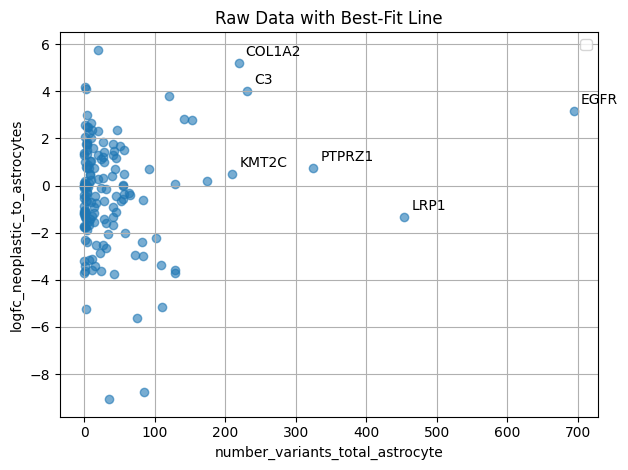

In [53]:
number_of_genes_to_label = 6

# Raw data
x = genes_grouped_df_astrocytes['number_variants_total_astrocyte']
y = genes_grouped_df_astrocytes['logfc_neoplastic_to_astrocytes']
genes = genes_grouped_df_astrocytes['gene_symbol']

mask = y > 10  # filter out y values > 10, and corresponding x's (None for nothing)

if mask is not None:
    x = x[~mask]
    y = y[~mask]
    genes = genes[~mask]

# Scatter plot
plt.scatter(x, y, alpha=0.6)

# # Best-fit line in linear space
# slope, intercept = np.polyfit(x, y, 1)
# x_fit = np.array([x.min(), x.max()])
# y_fit = slope * x_fit + intercept
# plt.plot(x_fit, y_fit, 'r--', label='Best-fit line')

# Annotate top number_of_genes_to_label x values
top_idx = x.nlargest(number_of_genes_to_label).index
for i in top_idx:
    plt.annotate(genes[i], (x[i], y[i]), textcoords="offset points", xytext=(5, 5), ha='left')

# Labels and formatting
plt.xlabel("number_variants_total_astrocyte")
plt.ylabel("logfc_neoplastic_to_astrocytes")
plt.title("Raw Data with Best-Fit Line")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
